# Análise de dados do cartolafc com Machine Learning

### Autor: Marku Vinícius
### Data: 10/06/2017

In [1]:
# import de bibliotecas utilizadas no projeto

import graphlab
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np


import sys  

reload(sys)  
sys.setdefaultencoding('utf8')

#constante que define o número da rodada atual do campeonato
rodada_atual = 13

#constante que define o número de partidas que o atleta deve ter jogado para ser sugerido
# <75% dos jogos>
num_min_matches = (rodada_atual-1)*0.75

#constante de desvio máximo permitido
std_max=2

#constante de valor máximo por posição
max_value = (109.43)/12

This non-commercial license of GraphLab Create for academic use is assigned to markuvinicius@gmail.com and will expire on May 19, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1501351180.log


## Import dos dados obtidos do cartola para o graphlab

In [2]:
data = graphlab.SFrame('atletas2.csv')

Unable to parse line "38748,Maicon,Avaí,Lateral,0,Nulo,0,2,0,0,0,0,0,4,1,0,0,0,0,1,0,0,1,0,,,0,0,0,0,0,0,-6,0,0,0,,,8,8,8,8,8,8,4.72,4.72,4.72,4.72"

Unable to parse line "73991,Walisson Maia,Coritiba,Zagueiro,-6.6,Dúvida,0,1,0,0,0,1,0,5,0,1,1,0,0,2,0,0,1,0,1.3,0,0,0,5,0,0,0,0,0,0,-6.6,5.87,4.67,4.67,4.67,5.31,5.31,5.31,5.31,5.31,5.31,5.31,3.02"

Unable to parse line "96089,Machado,Grêmio,Meia,0,Nulo,0,1,0,0,0,7,0,5,0,0,0,0,0,2,0,0,1,0,0,0,9.7,0,0,0,0,0,0,0,-5.8,0,1,1,4.11,4.11,4.11,4.11,4.11,4.11,4.11,4.11,2.04,2.04"

3 lines failed to parse correctly

Parsing completed. Parsed 100 lines in 0.036956 secs.

Finished parsing file /Users/Marku/Documents/WorkSpace/cartolafc-ml/atletas2.csv

Unable to parse line "38748,Maicon,Avaí,Lateral,0,Nulo,0,2,0,0,0,0,0,4,1,0,0,0,0,1,0,0,1,0,,,0,0,0,0,0,0,-6,0,0,0,,,8,8,8,8,8,8,4.72,4.72,4.72,4.72"

Unable to parse line "73991,Walisson Maia,Coritiba,Zagueiro,-6.6,Dúvida,0,1,0,0,0,1,0,5,0,1,1,0,0,2,0,0,1,0,1.3,0,0,0,5,0,0,0,0,0,0,-6.6,5.87,4.67,4.67,4.67,5.31,5.31,5.31,5.31,5.31,5.31,5.31,3.02"

Unable to parse line "96089,Machado,Grêmio,Meia,0,Nulo,0,1,0,0,0,7,0,5,0,0,0,0,0,2,0,0,1,0,0,0,9.7,0,0,0,0,0,0,0,-5.8,0,1,1,4.11,4.11,4.11,4.11,4.11,4.11,4.11,4.11,2.04,2.04"

3 lines failed to parse correctly

Finished parsing file /Users/Marku/Documents/WorkSpace/cartolafc-ml/atletas2.csv

Parsing completed. Parsed 825 lines in 0.014495 secs.

## Limpa os atletas que não possuem nenhum scout ou não pontuaram nas últimas rodadas

In [3]:
#apenas features de scouts
min_scouts = ["FD","G","CA","FC","FS","DD","GS","PP",
               "SG","CV","FT","A","PE","RB","DP","I","FF"]

#apenas features de ratings passados (até rodada atual)
ratings_scouts = [ "R{}".format(x) for x in range(1,rodada_atual-1) ]

data = data.dropna(columns=ratings_scouts,how='any')

ratings_scouts.append("RT")
ratings_scouts.append("RM")
ratings_scouts.append("NP")
ratings_scouts.append("MC")
ratings_scouts.append("STD")

#todas as features (scouts + ratings)
feat_scouts = min_scouts + ratings_scouts

min_scouts.append("RT")
min_scouts.append("RM")
min_scouts.append("NP")
min_scouts.append("MC")
min_scouts.append("STD")

#aplica função para calcular a soma de todos os ratings de cada atleta até a rodada atual

#transforma posição do atleta em número para cálculo
def def_position(row):
    if (row['posicao']=='Técnico'):
        return 0
    elif (row['posicao']=='Goleiro'):
        return 1
    elif (row['posicao']=='Zagueiro'):
        return 2
    elif (row['posicao']=='Lateral'):
        return 3
    elif (row['posicao']=='Meia'):
        return 4
    elif (row['posicao']=='Atacante'):
        return 5  
    
#calcula a quantidade de jogos
def count_matches(row):
    qtd=0
    for i in range(1,rodada_atual):
        if ( str( row['R{}'.format(i)] ) != '' ) & ( row['R{}'.format(i)] != 0 ):
            qtd=qtd+1
    return qtd

def std_ratings(row):
    rat = [ row["R{}".format(x)] for x in range(1,rodada_atual) ] 
    np_rat = np.array(rat)
    return np.std( np_rat )
        
#soma dos últimos ratings
def sum_ratings(row):
    total_rating=0
    for i in range(1,rodada_atual):
        total_rating+=row['R{}'.format(i)]
    return total_rating

#média dos últimos ratings
def mean_ratings(row):
    total_rating=0
    for i in range(1,rodada_atual):
        total_rating+=row['R{}'.format(i)]
    return ( total_rating / (rodada_atual-1))

data['RT'] = data.apply(sum_ratings)
data['RM'] = data.apply(mean_ratings)
data['NP'] = data.apply(def_position)
data['MC'] = data.apply(count_matches)
data['STD'] = data.apply(std_ratings)

#remove os atletas que não possuem nenhum scout acumulado
data = data[(data['RT']!=0)]

## Análise dos times

In [4]:
# agrupa os times

clubes = data.groupby( ['clube'], 
                { 'media_ultima_pontuacao'   : graphlab.aggregate.MEAN('ultima_pontuacao') ,
                  'media_acumulada' : graphlab.aggregate.MEAN('RM') ,  
                  'std' : graphlab.aggregate.STD('RM')  
                }
                      
            ).sort(['media_acumulada'],ascending=False)

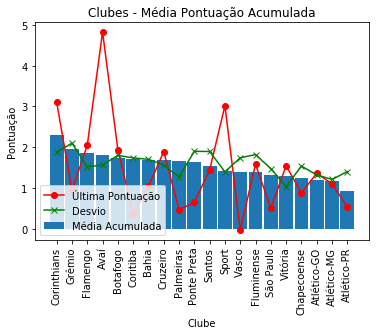

In [5]:
%matplotlib inline

plt.Figure(figsize=(10,10))
#plt.bar(clubes['clube'] , clubes['media'] ,width=0.8 )
#clubes['clube','media'].plot()
fontsize2use = 10   
fontprop = fm.FontProperties(size=fontsize2use)

plt.bar( 
            range( len( clubes ) ) ,
            clubes['media_acumulada'] ,
            width=0.9
)

plt.plot( 
            range( len( clubes ) ) ,
            clubes['media_ultima_pontuacao'] ,
            marker='o',c='r'
)

plt.plot( 
            range( len( clubes ) ) ,
            clubes['std'] ,
            marker='x',c='g'
)

plt.xticks(range(len(clubes)),clubes['clube'])
plt.xticks(rotation=90)
plt.xlabel('Clube')
plt.ylabel('Pontuação')
plt.title('Clubes - Média Pontuação Acumulada')

plt.legend(('Última Pontuação','Desvio','Média Acumulada'),loc=3)

## Separação dos datasets e criação do modelo

### features: scouts do cartola

In [6]:
train_data , test_data = data.random_split(.8,seed=0)

In [7]:
# modelo com apenas os scouts de jogo de cada atleta
scouts_model = graphlab.linear_regression.create(
                                                    dataset=train_data,
                                                    target='ultima_pontuacao',
                                                    features=min_scouts,
                                                    validation_set=test_data,
                                                    verbose=False
                                                )

# modelo com apenas os ratings de cada atleta
ratings_model = graphlab.linear_regression.create(
                                                    dataset=train_data,
                                                    target='ultima_pontuacao',
                                                    features=ratings_scouts,
                                                    validation_set=test_data,
                                                    verbose=False
                                                )

# modelo com apenas todas as features (scout + histórico de ratings)
full_model = graphlab.linear_regression.create(
                                                dataset=train_data,
                                                target='ultima_pontuacao',
                                                features=feat_scouts,
                                                validation_set=test_data,
                                                verbose=False
                                            )

## Plota a escala dos erros de cada um dos 3 modelos

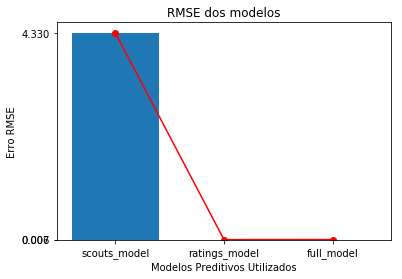

In [8]:
plt.Figure()
x=[1,2,3]
y=[scouts_model.evaluate(test_data)['rmse'] , 
   ratings_model.evaluate(test_data)['rmse'],
   full_model.evaluate(test_data)['rmse']]

plt.plot( x , y ,marker='o',c='r' )
plt.bar( x , y ,width=0.8 )
plt.xlabel('Modelos Preditivos Utilizados')
plt.ylabel('Erro RMSE')
plt.xticks(range(1,4),['scouts_model','ratings_model','full_model'])
plt.yticks(y)
plt.title('RMSE dos modelos')

In [9]:
data['pd1'] = scouts_model.predict(data)
data['pd2'] = ratings_model.predict(data)
data['pd3'] = full_model.predict(data)
data['erro1'] = data['ultima_pontuacao'] - data['pd1']
data['erro2'] = data['ultima_pontuacao'] - data['pd2']
data['erro3'] = data['ultima_pontuacao'] - data['pd3']

In [10]:
%matplotlib inline

def plot_athlete_performance(apelido):
    atleta1=data[data['apelido']==apelido]

    if ( len(atleta1) == 1 ):
        plt.Figure(figsize=(20,10))

        x=[]
        y=[]

        for i in range(1,rodada_atual):
            x.append(i)
            y.append(atleta1['R{}'.format(i)])

        plt.plot( x , y , marker='o' , c='r')
        
        plt.plot( rodada_atual , atleta1['pd1'],marker='x',c='b')
        plt.plot( rodada_atual , atleta1['pd2'],marker='v',c='g')
        plt.plot( rodada_atual , atleta1['pd3'],marker='.',c='y')
        plt.bar( rodada_atual, atleta1['RM'] , width=0.8 )
        plt.xlabel('turno')
        plt.ylabel('pontuacao')
        plt.title('Performance {} - {}'.format(atleta1['apelido'],atleta1['clube']))
        plt.legend(('histórico','scouts_model','ratings_model','full_model','média'))
    else:
        print('Atleta não encontrado')

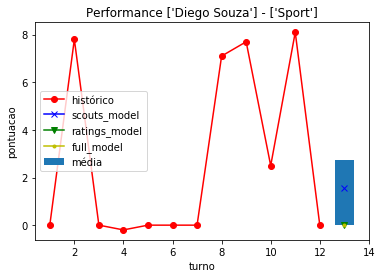

In [11]:
plot_athlete_performance('Diego Souza')

## Função para plotar os atletas por posição

In [12]:
data.show()

In [12]:
%matplotlib inline

def plot_position_graph(sframe):
    m = len(sframe)
    fig,axes = plt.subplots(2,m/2,sharey=True,figsize=(15,10))
    #fig = plt.figure(figsize=(8, 6)) 
    c='r'
    marker='o'

    for n in range(len(axes.flat)):
        ax = axes.flat[n]
        x=[]
        y=[]

        for rodada in range(1,rodada_atual):
            x.append( rodada )
            y.append( sframe[n]['R{}'.format(rodada)] )

        #print( str(goleiros[n]['apelido']).encode("utf-8") )        
        ax.plot( x , y , marker=marker , c=c )

        #plota a previsão no modelo completo - em azul
        ax.plot( rodada_atual , sframe[n]['pd1'] , marker='o' , c='b' )
        #plota a previsão no modelo resumido - em verde
        ax.plot( rodada_atual , sframe[n]['pd2'] , marker='x' , c='g' )
        #plota a previsão no modelo resumido - em amarelo
        ax.plot( rodada_atual , sframe[n]['pd3'] , marker='v' , c='y' )
        
        ax.bar( rodada_atual, sframe[n]['RM'] , width=0.8 )


        x.append(rodada_atual)    

        ax.set_xlabel('turno')
        ax.set_ylabel('pontuacao')
        ax.set_title( sframe[n]['apelido'] + '-' + sframe[n]['clube'] )
        ax.set_xticks(x)

        ax.legend(('histórico', 'scouts_model', 'ratings_model','full_model','média'))

# Análise dos goleiros

## Análise gráfica da performance versus pontuações previstas para cada goleiro

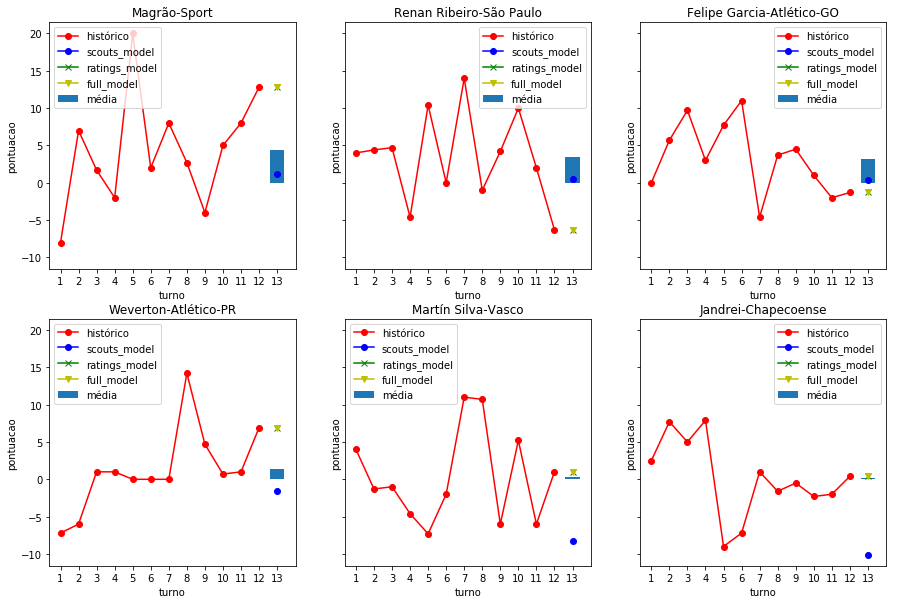

In [13]:
goleiros = data[(data['posicao']=='Goleiro') & 
                (data['status']=='Provável') & 
                (data['MC']>=num_min_matches) &
                (data['P{}'.format(rodada_atual-1)] <= max_value )
               ]
#goleiros = goleiros.sort(['pd3','pd2','pd1'],ascending=False)[0:10]
goleiros = goleiros.sort(['pd1','pd2','pd3'],ascending=False)[0:10]#.sort('STD',ascending=True)

plot_position_graph(goleiros)

# Análise dos Zagueiros

## Análise gráfica da performance versus pontuações previstas para cada goleiro

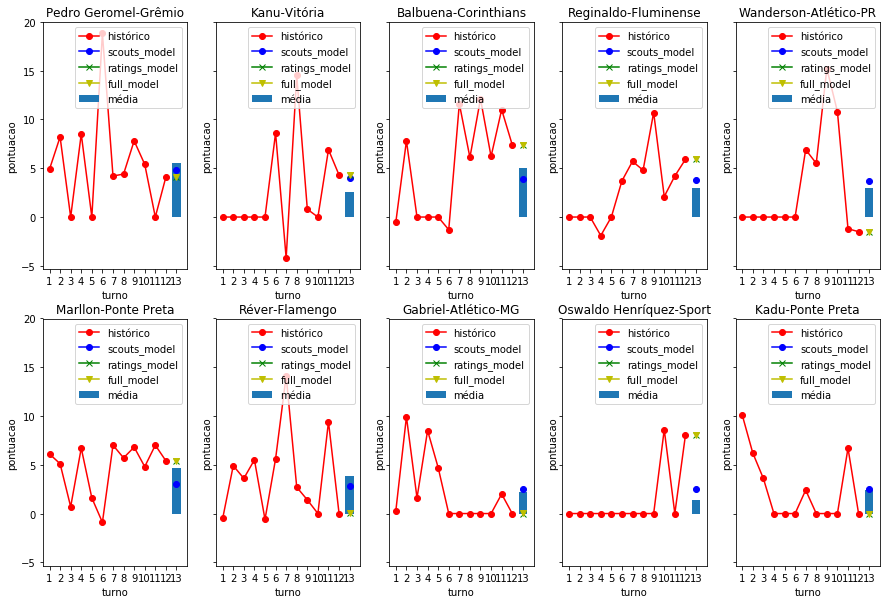

In [14]:
zagueiros = data[
                    (data['posicao']=='Zagueiro') & 
                    (data['status']=='Provável') #& 
                    #(data['MC']>=num_min_matches) &
                    #(data['P{}'.format(rodada_atual-1)] <= max_value )
                ]
zagueiros = zagueiros.sort(['pd1','pd2','pd3'],ascending=False)[0:10]#.sort('STD',ascending=True)

plot_position_graph(zagueiros)


## Análise dos Laterais

### Análise gráfica da performance versus pontuações previstas para cada atleta

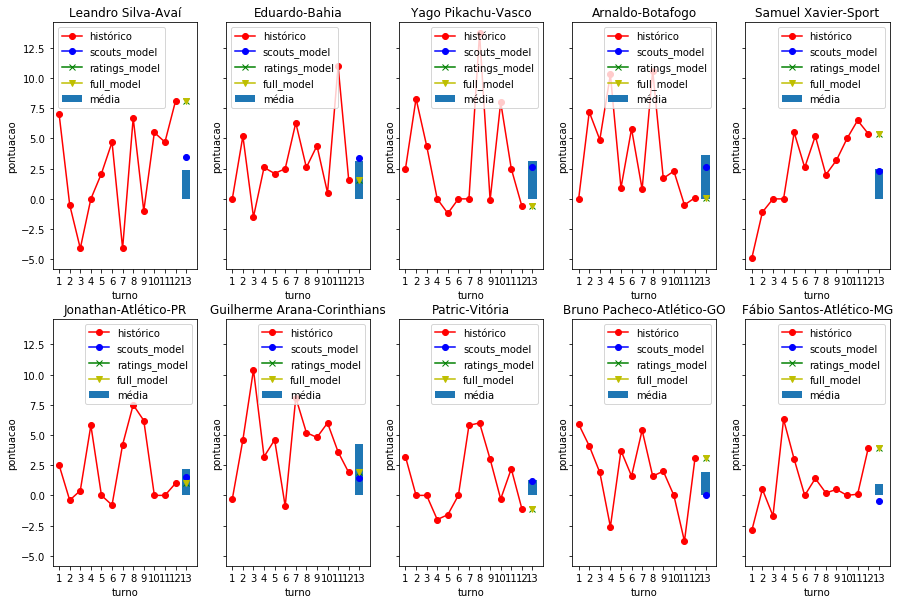

In [15]:
laterais = data[
                (data['posicao']=='Lateral') & 
                (data['status']=='Provável') & 
                (data['MC']>=num_min_matches) &
                (data['P{}'.format(rodada_atual-1)] <= max_value )
               ]
laterais = laterais.sort(['pd1','pd2','pd3'],ascending=False)[0:10]#.sort('STD',ascending=True)

plot_position_graph(laterais)

# Análise dos Meias

## Análise gráfica da performance versus pontuações previstas para cada atleta

In [19]:
max_value = 69.37/7

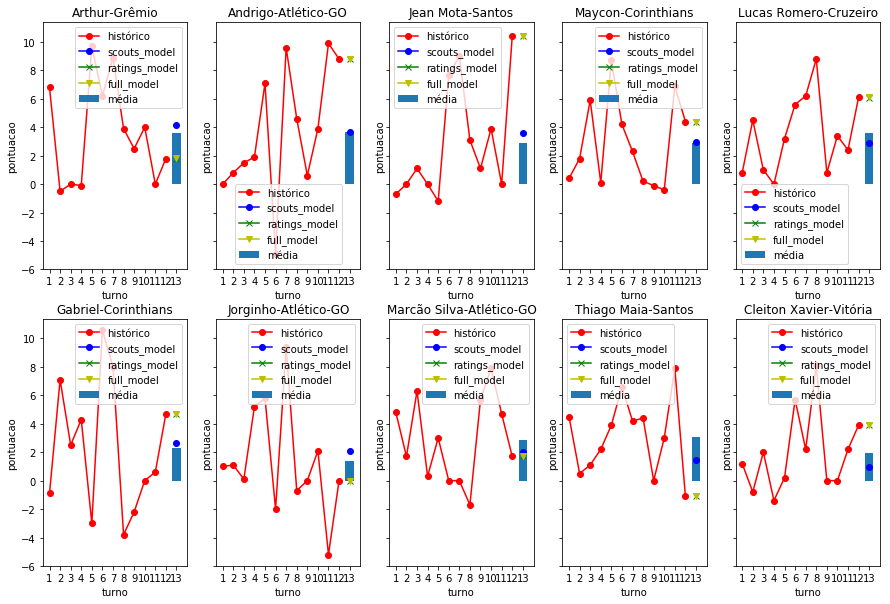

In [16]:
meias = data[
                (data['posicao']=='Meia') & 
                (data['status']=='Provável') & 
                (data['MC']>=num_min_matches) &
                (data['P{}'.format(rodada_atual-1)] <= max_value )
            ]
meias = meias.sort(['pd1','pd2','pd3'],ascending=False)[0:10]#.sort('STD',ascending=True)

plot_position_graph(meias)

# Análise dos Atacantes

## Análise gráfica da performance versus pontuações previstas para cada atleta

In [20]:
max_value = 45.02/4

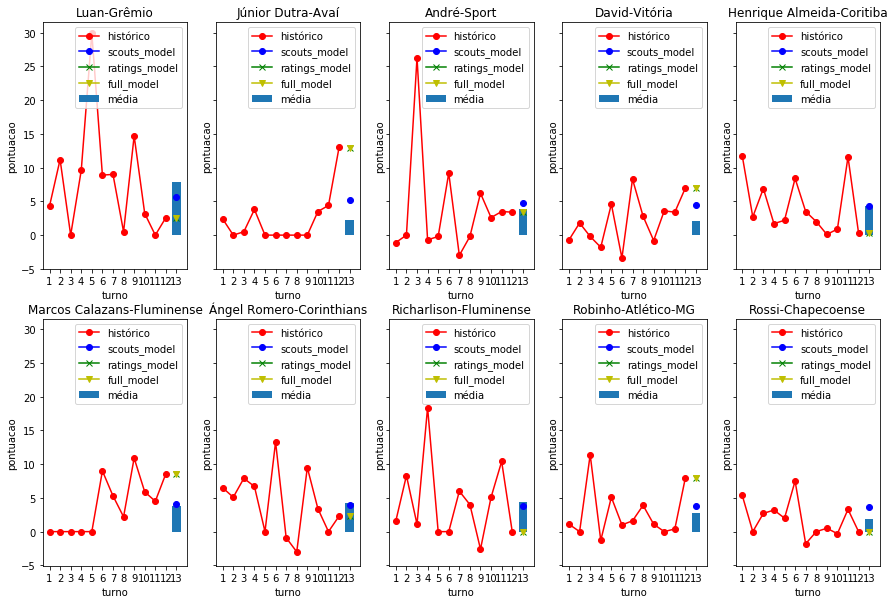

In [17]:
atacantes = data[
                    (data['posicao']=='Atacante') & 
                    (data['status']=='Provável') #& 
                    #(data['MC']>=num_min_matches) &
                    #(data['P{}'.format(rodada_atual-1)] <= max_value ) 
                ]
atacantes = atacantes.sort(['pd1','pd2','pd3'],ascending=False)[0:10]#.sort('STD',ascending=True)

plot_position_graph(atacantes)

# Análise dos Técnicos

## Análise gráfica da performance versus pontuações previstas para cada atleta

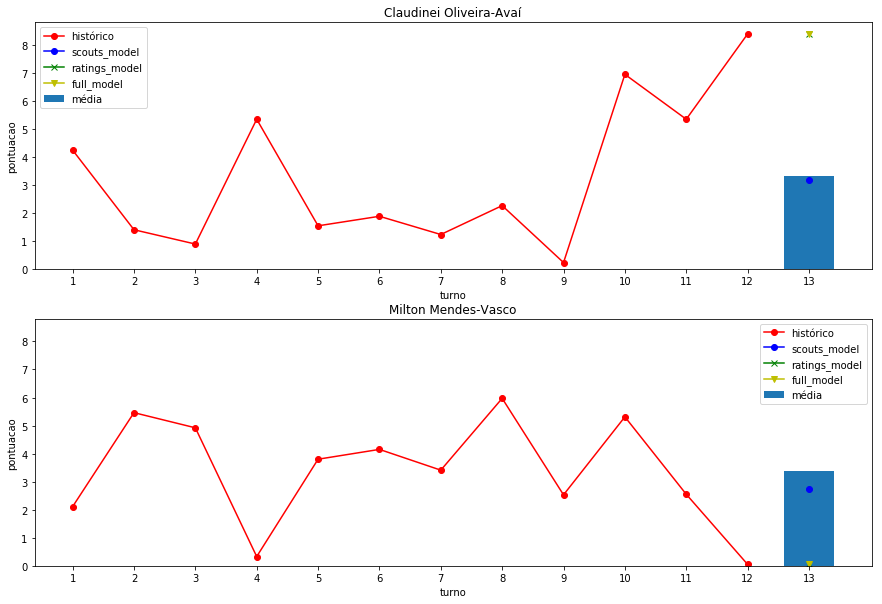

In [18]:
tecnicos = data[
                (data['posicao']=='Técnico') & 
                (data['status']=='Provável') & 
                (data['MC']>=num_min_matches) &
                (data['P{}'.format(rodada_atual-1)] <= max_value )
                ]
tecnicos = tecnicos.sort(['pd1','pd2','pd3'],ascending=False)[0:10]#.sort('STD',ascending=True)

plot_position_graph(tecnicos)

In [26]:
print 'e ai gordao'